In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import scipy as sp
import os
import sys
import re
from PIL import Image
import requests
import warnings
warnings.filterwarnings('ignore')

In [13]:
books = pd.read_csv('/opt/ml/data/books.csv')
users = pd.read_csv('/opt/ml/data/users.csv')
train = pd.read_csv('/opt/ml/data/train_ratings.csv')

# 데이터 프레임 시각화

In [42]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-z:,]', '') # 특수문자 제거
# trans_wrong_loc = {'idaho, idaho' : 'idaho',
#                         'england' : 'united kingdom',
#                         # 'united kingdom, united kingdom' : 'united kingdom',
#                         ',,' : ',',
#                         'fpo, ap' : '',
#                        }
# for key, value in trans_wrong_loc.items():
#     users['location'] = users['location'].str.replace(key, value)

users['location_city'] = users['location'].apply(lambda x : x.split(',')[0].strip()) # split : city, state, country
users['location_state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan)
users = users.replace('n/a', np.nan)  # location이 n/a, n/a, n/a 로 표시된 경우

In [41]:
df = users[(users['location_city'].notnull())&(users['location_country'].notnull())&(users['location_state'].isna())]
df[['user_id', 'location_state', 'location_city', 'location_country']]

,user_id,location_state,location_city,location_country
633,271622,NaN,malmok,aruba
720,8674,NaN,singapore,singapore
732,10570,NaN,singapore,singapore
748,12331,NaN,athens,greece
772,16155,NaN,kuala lumpur,malaysia
...,...,...,...,...
68008,272386,NaN,rotorua,new zealand
68052,275874,NaN,zürich,switzerland
68063,276660,NaN,singapore,singapore
68064,276729,NaN,rijeka,croatia


In [40]:
dff = users[users['location_city'].notnull() & users['location_country'].isna()]
dff[['user_id', 'location_city', 'location_country']]

,user_id,location_city,location_country
6,116866,ottawa,NaN
32,115097,seattle,NaN
49,245827,albuquerque,NaN
72,226745,humble,NaN
120,38718,aloha,NaN
...,...,...,...
67797,257311,lisbon,NaN
67929,267240,houston,NaN
67930,267276,sammamish,NaN
68058,276221,calgary,NaN


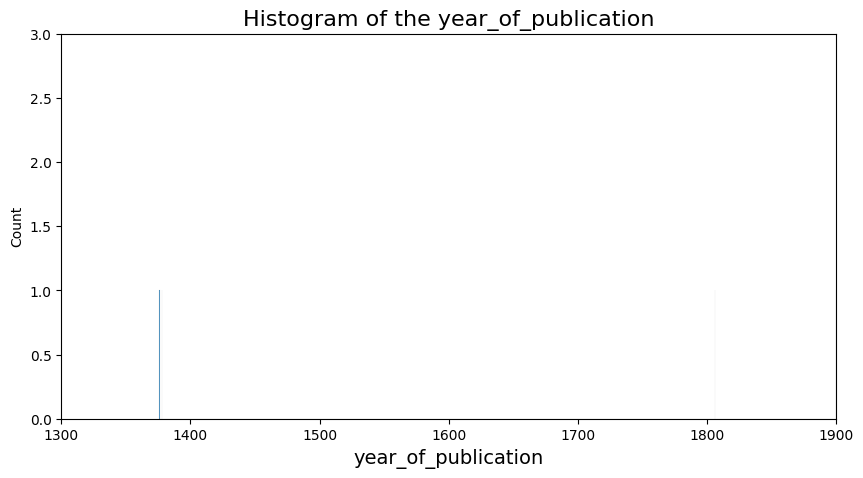

In [53]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'])
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.xlim(1300, 1900)
plt.ylim(0,3)
plt.show()

In [44]:
# books.loc[104259, 'year_of_publication'] = 2010.0
# books.loc[121860, 'year_of_publication'] = 1997.0
# books = books.drop(np.where(books['year_of_publication'] < 1900)[0][0]).reset_index(drop=True)
books.loc[[104259, 121860]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
104259,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378.0,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,fa,['Fantasy fiction'],"Mahnaz, the only daughter of a traditional ari...",images/9643112136.01.THUMBZZZ.jpg
121860,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376.0,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,NaN,NaN,NaN,images/964442011X.01.THUMBZZZ.jpg


In [50]:
books.loc[np.where(books['year_of_publication'] < 1900), 'year_of_publication']

104259    1378.0
121860    1376.0
129205    1806.0
Name: year_of_publication, dtype: float64

# FS 시각화

In [9]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [10]:
users['age'] = users['age'].fillna(int(users['age'].median()))
users['age_map'] = users['age'].apply(age_map)

In [15]:
train_df = train.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')

In [16]:
train_df['age'] = train_df['age'].fillna(int(train_df['age'].median()))
train_df['age_map'] = train_df['age'].apply(age_map)

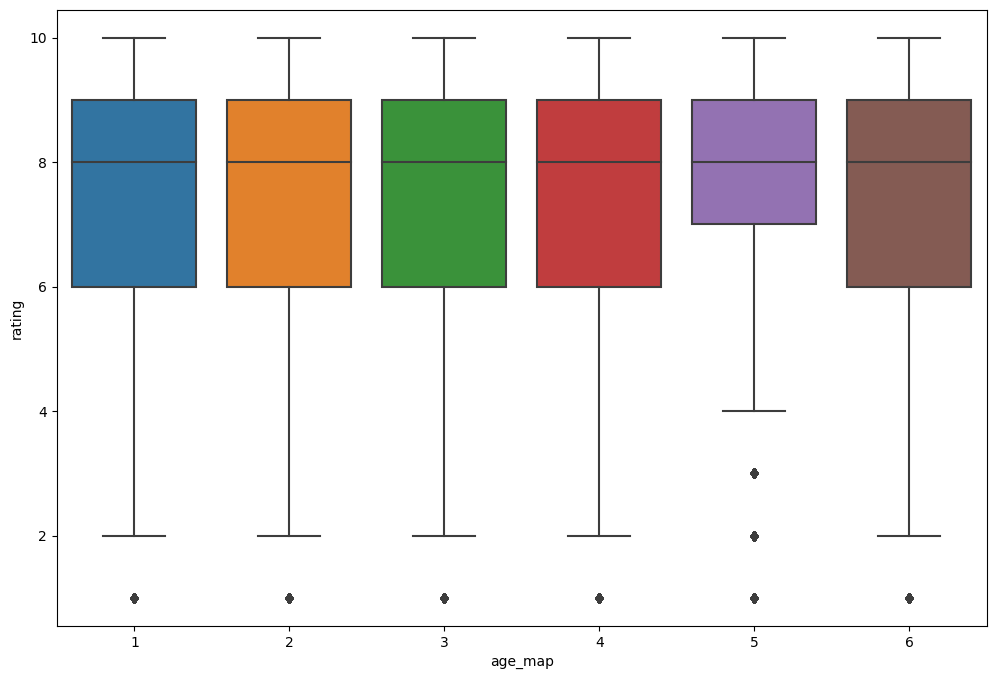

In [35]:
plt.figure(figsize=(12,8))
sns.boxplot(x='age_map', y='rating', data=train_df)
plt.xlabel('age_map')
plt.ylabel('rating')
plt.show()

KeyboardInterrupt: 

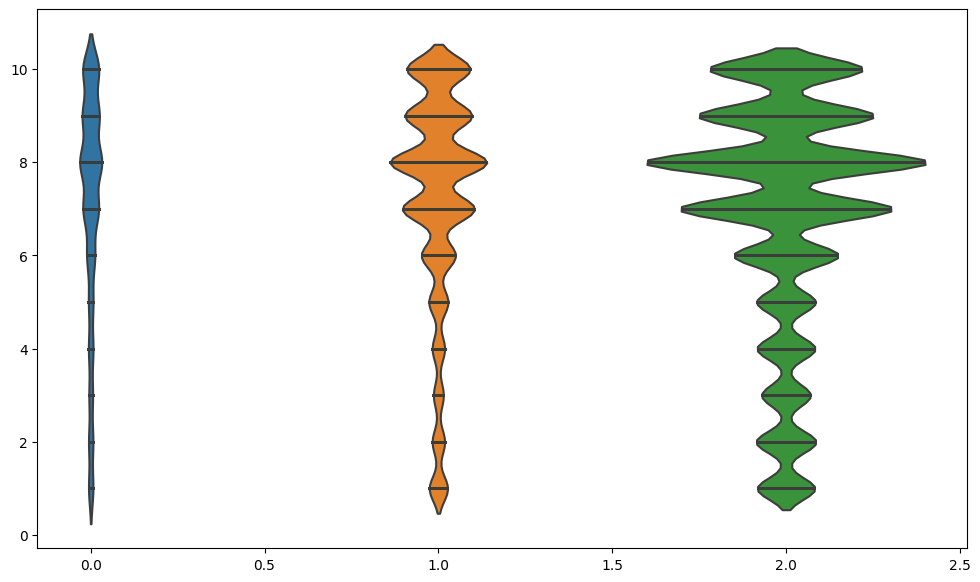

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
sns.violinplot(x='age_map', y='rating', data=train_df, ax=ax,
               scale='count', inner='stick'
              )
plt.show()

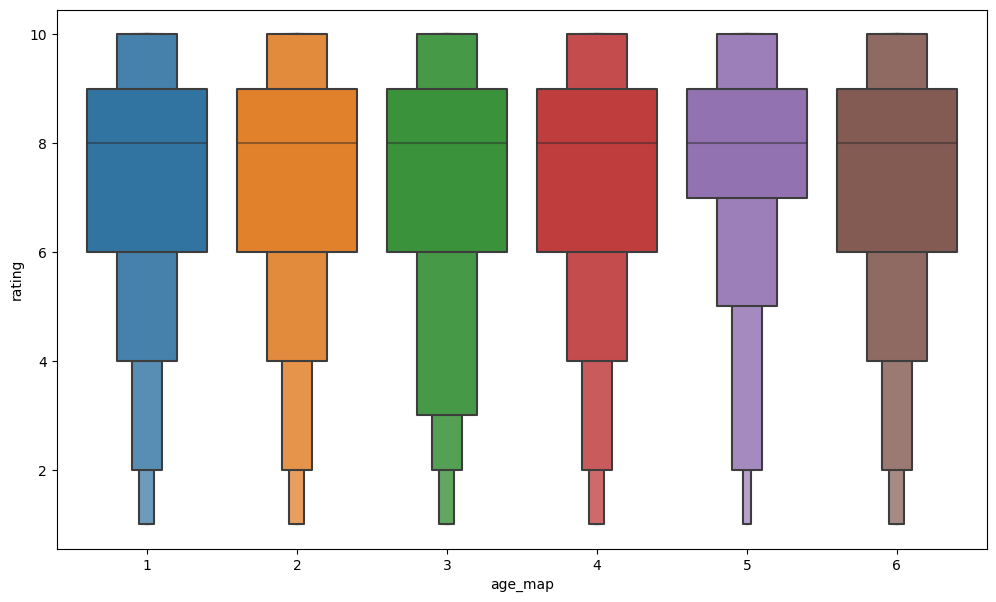

In [32]:
fig, axes = plt.subplots(1,1, figsize=(12, 7))
sns.boxenplot(x='age_map', y='rating', data=train_df, ax=axes,
             order=sorted(train_df['rating'].unique()))
plt.xlim(-0.6, 5.6)
plt.show()

# RMSE 시각화

In [54]:
import plotly
import plotly.express as px 
print(plotly.__version__)
import seaborn as sns

5.14.1


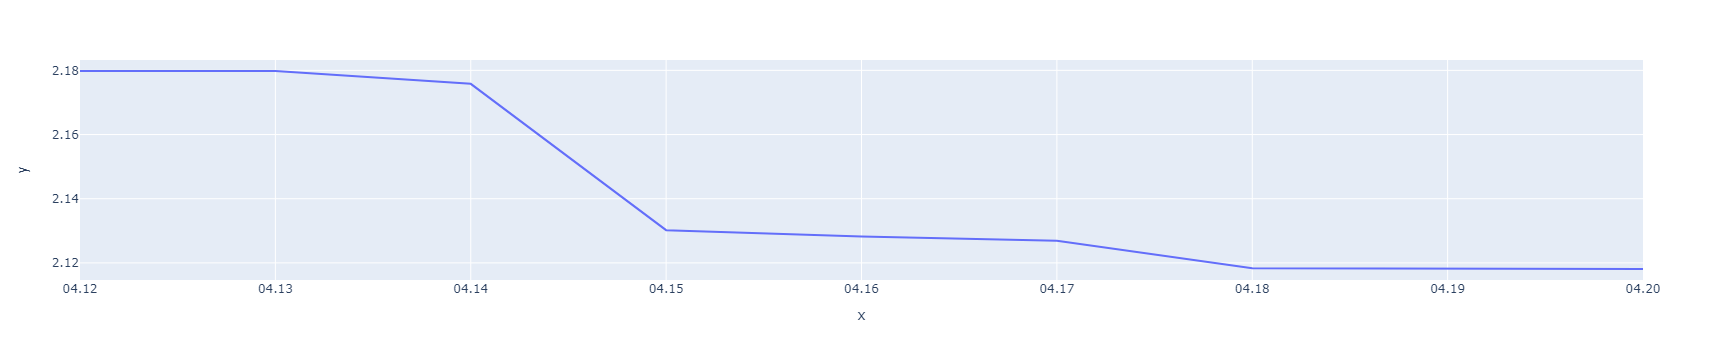

In [67]:
rmse = [2.1798, 2.1798, 2.1758, 2.1302, 2.1282, 2.1269, 2.1183, 2.1183, 2.1181]
date = ['04.{}'.format(i) for i in range(12,21)]
why = ['Catboost', 'Ensemble', 'K-Fold', 'EDA', 'Min-Max Scale', 'HP-Tune', 'Ensemble', 'Offline1', 'Offline2']
fig = px.line(x=date,
              y=rmse,
              # color='month',
            )
fig.update_traces(text=rmse)  # 점의 값(value) 표시
fig.show()

In [ ]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.plot(x, y,
       color='lightgray',
       linewidth=2,)

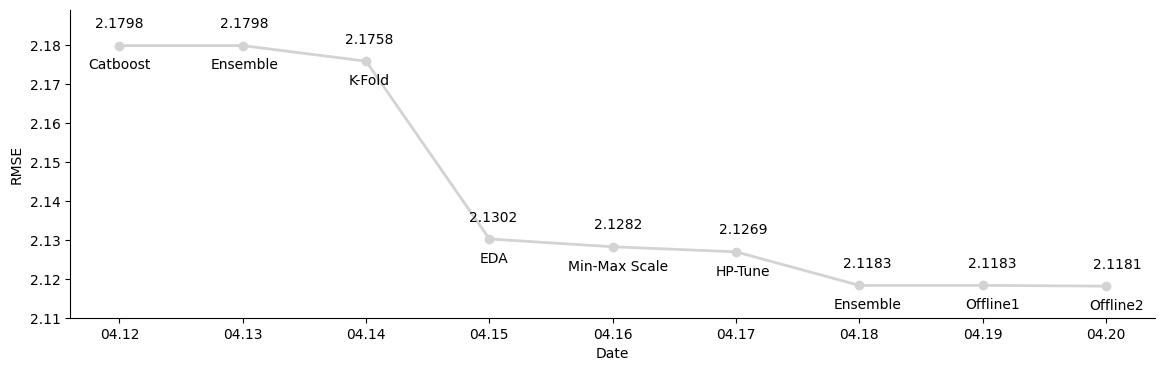

In [90]:
fig = plt.figure(figsize=(14, 4))

ax = fig.add_subplot(111)
ax.plot(date,rmse,
        color='lightgray',
        linewidth=2,
        marker='o')

ax.set_xlabel('Date')
ax.set_ylabel('RMSE')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(2.11, 2.189)

for i, j in enumerate(rmse):
    ax.annotate(j, (date[i], rmse[i]+0.003), textcoords='offset points', ha='center', va='bottom')
    ax.annotate(why[i], (date[i], rmse[i]-0.004), textcoords='offset points', ha='center', va='top')

# # max
# ax.plot([-1, x[np.argmax(y)]], [np.max(y)]*2,
#         linestyle='--', color='tomato'
#        )

# ax.scatter(x[np.argmax(y)], np.max(y), 
#             c='tomato',s=50, zorder=20)

# # min
# ax.plot([-1, x[np.argmin(y)]], [np.min(y)]*2,
#         linestyle='--', color='royalblue'
#        )
# ax.scatter(x[np.argmin(y)], np.min(y), 
#             c='royalblue',s=50, zorder=20)

plt.show()